# <center>Report

## <center> Zid: z5235878

## <center> Name: Su Zhaokun

## <center> Course: comp9321

In [13]:
import pandas as pd
import numpy as np
import sys
import ast
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr
from sklearn.metrics import *

## Load Data

In [14]:
# $ python3 z{id}.py path1 path2
def load_data(path1, path2):
    df_train_origin = pd.read_csv(path1)
    df_validation_origin = pd.read_csv(path2)
    return df_train_origin, df_validation_origin

## Feature Engineering

#### Firstly, we need to make a relatively accurate prediction for movie "revenue" (part_1) and classify the rating for different movies (part_2) when it comes to our job.
#### Based on our basic assumption, in general, a high revenue means a good rating and vice versa. We cannot predict revenue using rateing and it is meaningless that make a classification for rateing using revenue. 
#### By naturally thinking,  I decide to use attributes list ["cast","crew","budget","original_language","genres","release_date","runtime"] to predict revenue since the remaining attributes are not very relevant to movie revenue or rating.

### original dataset:
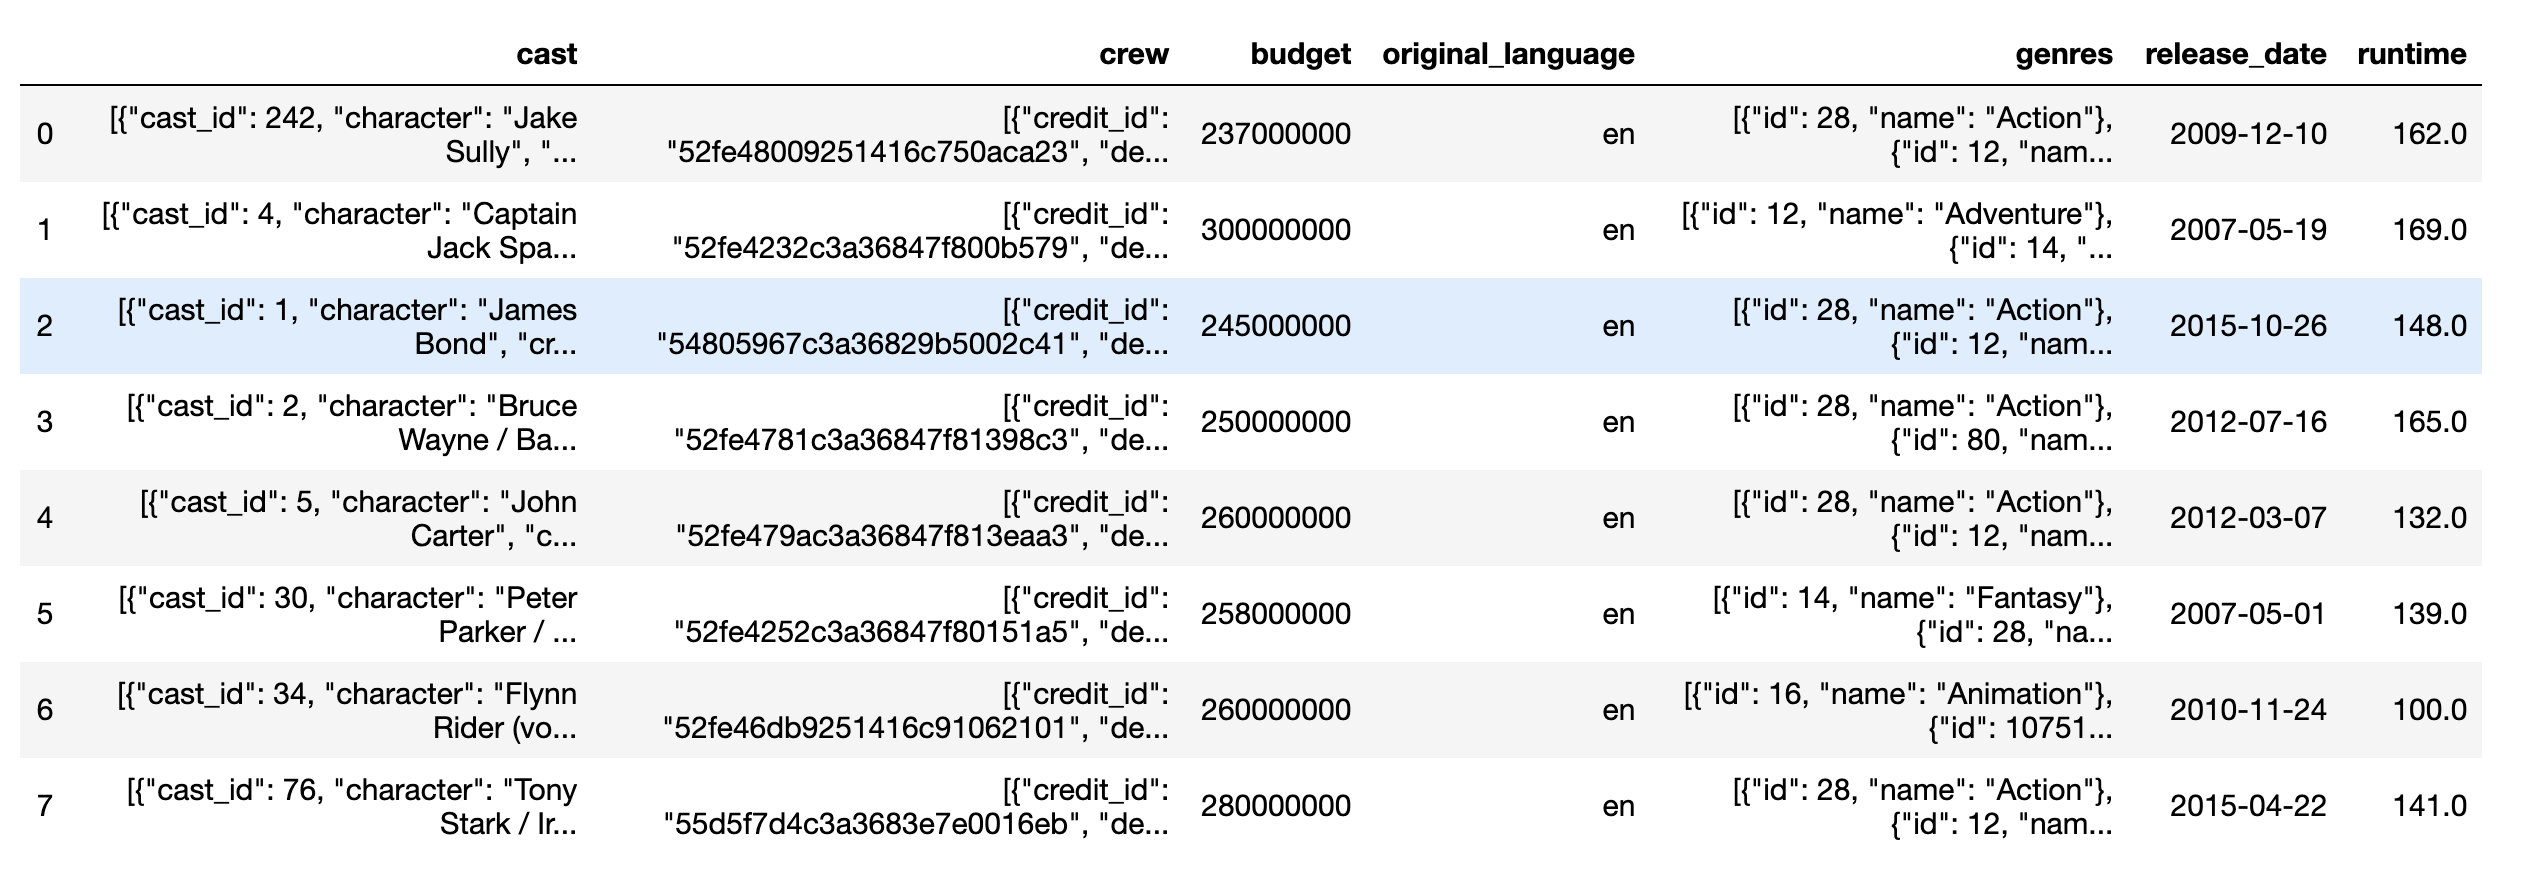

In [15]:
def feature_engineering(df_train_origin, df_validation_origin):
    feature_columns = ["cast", "crew", "budget", "original_language", "genres", "release_date", "runtime"]
    df_train_X = df_train_origin[feature_columns]  # part_1 training data X
    df_validation_X = df_validation_origin[feature_columns]  # part_1 validation data X
    return df_train_X, df_validation_X

## Data Processing

#### Now, we get all attributes that we want to use to make regression and classification, the next thing is that we should convert data to what we can use to our model and change some format data

#### For "cast" column, I choose the name of the leader star as feature, and encoding it, since the leader actor's name is significantly relevant for its value.
#### For "crew" column, I choose the name of the Director as feature because Director normally influence revenue of a movie for ordinary people, and encoding it.
#### For "budget" column, I can directly use original data.
#### For "original_language" column, I encode different language with different code.
#### For "genres" column, I use the first type of a movie as our feature and encode it.
#### For "release_date" column, considering the specific year and date are nothing to do with revenue, so I extract the month value to train our model
#### For "runtime" column, I can directly use original data.

### datasets after pre-processing:
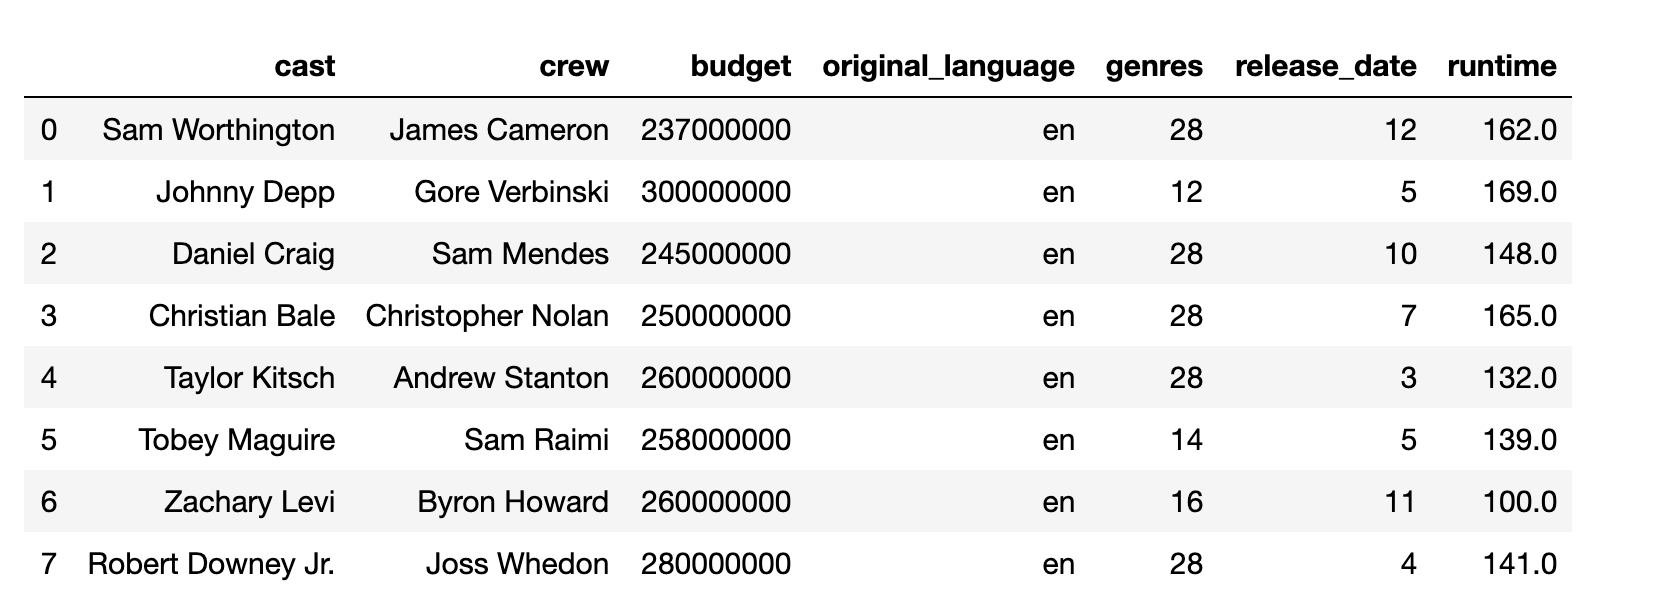


In [16]:
def data_pre_processing(df_train_X, df_validation_X):
    # regulazition all data sets

    # step 1: extract cast lead name in cast
    # for training data
    lead_star_list_train = []  # a list stores all leading stars
    for cast in df_train_X['cast']:
        cast = ast.literal_eval(cast)
        lead_star_list_train.append(cast[0]['name'])
    df_train_X['cast'] = lead_star_list_train

    # for testing data
    lead_star_list_validation = []  # a list stores all leading stars
    for cast in df_validation_X['cast']:
        cast = ast.literal_eval(cast)
        lead_star_list_validation.append(cast[0]['name'])
    df_validation_X['cast'] = lead_star_list_validation

    # step 2: extract director name in crew
    # for training data
    director_list_train = []  # a list stores all leading stars
    for crew in df_train_X['crew']:
        crew = ast.literal_eval(crew)
        for member in crew:
            if member['job'] == "Director":
                director_list_train.append(member['name'])
                break
    df_train_X['crew'] = director_list_train

    # for testing data
    director_list_validation = []  # a list stores all leading stars
    for crew in df_validation_X['crew']:
        crew = ast.literal_eval(crew)
        for member in crew:
            if member['job'] == "Director":
                director_list_validation.append(member['name'])
                break
    df_validation_X['crew'] = director_list_validation

    # step 3: extract main genres
    # for training data
    genres_list_train = []
    for pc in df_train_X['genres']:
        pc = ast.literal_eval(pc)
        genres_list_train.append(pc[0]['id'])
    df_train_X['genres'] = genres_list_train
    # for testing data
    genres_list_validation = []
    for pc in df_validation_X['genres']:
        pc = ast.literal_eval(pc)
        genres_list_validation.append(pc[0]['id'])
    df_validation_X['genres'] = genres_list_validation

    # step 4: extract all months
    # for training data
    month_train = []
    for date in df_train_X['release_date']:
        month_train.append(int(date[5:7]))
    df_train_X['release_date'] = month_train

    # for testing data
    month_validation = []
    for date in df_validation_X['release_date']:
        month_validation.append(int(date[5:7]))
    df_validation_X['release_date'] = month_validation

    return df_train_X, df_validation_X

## Format Converting (Encoding)

#### After pre-processing our data sets, the next thing needs to handle is encoding.
#### For columns ["cast", "crew", "original_language", "genres"], we need to convert all those names and language labels into numbers. we encode those data by using integers.(e.g. we can encode 13 different kinds of language labels with integer from 1 to 13), Similiarly, we can encode other attributes using the same way.

### dataset after encoding:
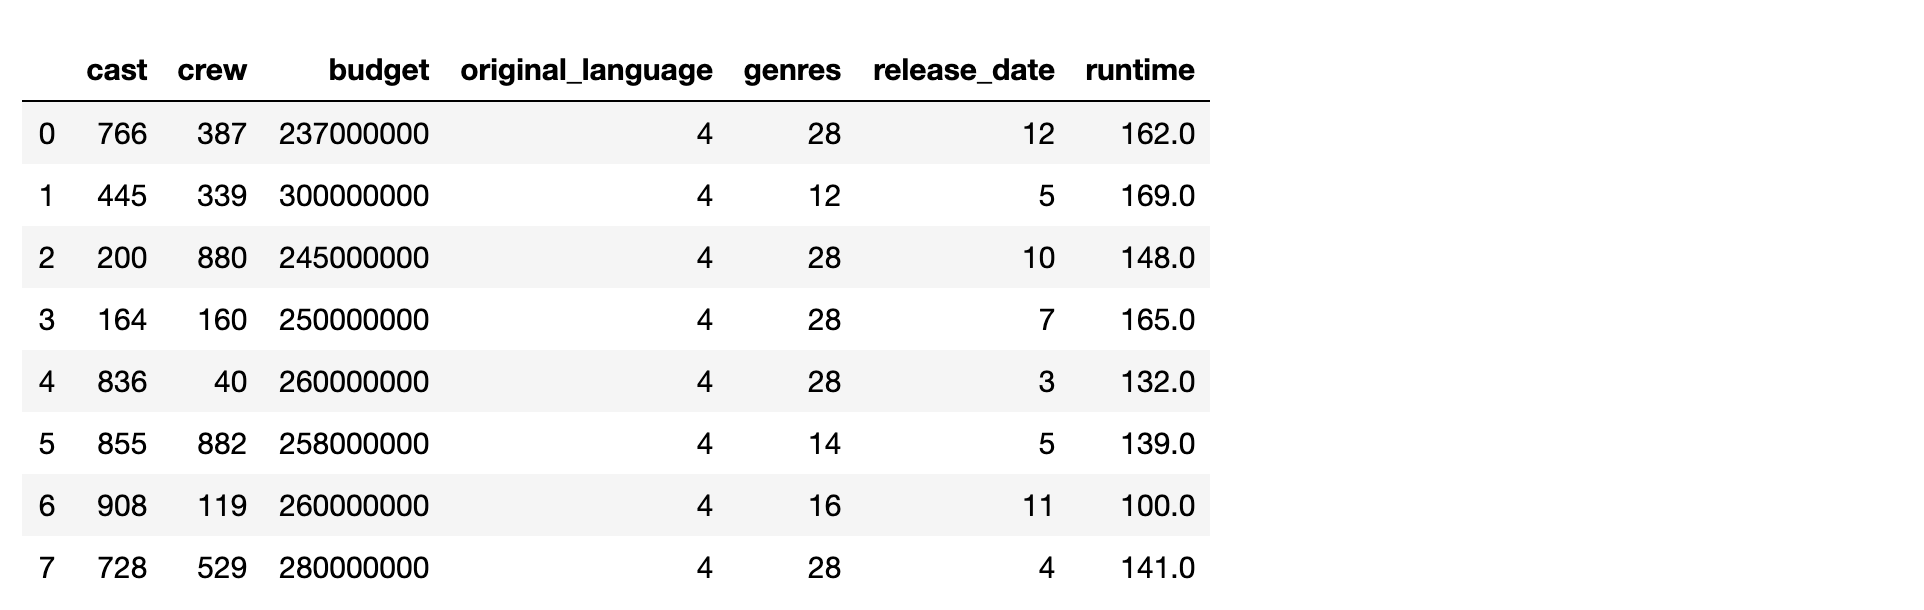

In [17]:
def data_encoding(df_train_X, df_validation_X):
    # encoding data
    cast_set = set(df_train_X['cast']).union(set(df_validation_X['cast']))
    cast_dict = dict()
    cast_list = sorted(list(cast_set))
    index = 1
    for name in cast_list:
        cast_dict[name] = index
        index += 1
    # convert name to id
    for i in range(len(df_train_X)):
        name = df_train_X.loc[i, 'cast']
        df_train_X.loc[i, 'cast'] = cast_dict[name]
    for i in range(len(df_validation_X)):
        name = df_validation_X.loc[i, 'cast']
        df_validation_X.loc[i, 'cast'] = cast_dict[name]

    crew_set = set(df_train_X['crew']).union(set(df_validation_X['crew']))
    crew_dict = dict()
    crew_list = sorted(list(crew_set))
    index = 1
    for name in crew_list:
        crew_dict[name] = index
        index += 1
    # convert name to id
    for i in range(len(df_train_X)):
        name = df_train_X.loc[i, 'crew']
        df_train_X.loc[i, 'crew'] = crew_dict[name]
    for i in range(len(df_validation_X)):
        name = df_validation_X.loc[i, 'crew']
        df_validation_X.loc[i, 'crew'] = crew_dict[name]

    language_set = set(df_train_X['original_language']).union(set(df_validation_X['original_language']))
    language_dict = dict()
    language_list = sorted(list(language_set))
    index = 1
    for name in language_list:
        language_dict[name] = index
        index += 1

    # convert name to id
    for i in range(len(df_train_X)):
        name = df_train_X.loc[i, 'original_language']
        df_train_X.loc[i, 'original_language'] = language_dict[name]
    for i in range(len(df_validation_X)):
        name = df_validation_X.loc[i, 'original_language']
        df_validation_X.loc[i, 'original_language'] = language_dict[name]
    return df_train_X, df_validation_X


## Train Our Model And Show Results

### For part1, we use LinearRegression Model to train our data sets and predict value of revenue of a specific movie.
### For part2, we use K Nearest Neighbors Model to train our data sets and predict the rank of a specific movie.
#### After that, we get all results of our model for part_1:

MSE:  9660489995057274.0

correlation:  0.09090825028512028

#### After that, we get all results of our model for part_2:

precision_score:  0.6252555315055315

recall_score:  0.6875

accuracy_score:  0.6875

In [22]:
df_train_origin, df_validation_origin = load_data("training.csv", "validation.csv")
df_train_X, df_validation_X = feature_engineering(df_train_origin, df_validation_origin)
df_train_X, df_validation_X = data_pre_processing(df_train_X, df_validation_X)
df_train_X, df_validation_X = data_encoding(df_train_X, df_validation_X)

# part1 model
model1 = LinearRegression()
model1.fit(df_train_X, df_train_origin['revenue'])
predicted_y_part1 = model1.predict(df_validation_X)

# generate summary.csv for part1
MSR = mean_squared_error(df_validation_origin['revenue'], predicted_y_part1)
correlation = pearsonr(df_validation_origin['revenue'], predicted_y_part1)[0]  # a tuple (correlaction, R-value)

# part2 model
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(df_train_X, df_train_origin['rating'])
predicted_y_part2 = model2.predict(df_validation_X)

# generate summary.csv for part2
average_precision = precision_score(df_validation_origin['rating'], predicted_y_part2, average="weighted")
average_recall = recall_score(df_validation_origin['rating'], predicted_y_part2, average="weighted")
accuracy = accuracy_score(df_validation_origin['rating'], predicted_y_part2)

In [23]:
print("MSE: ", MSR)
print("correlation: ", correlation)

MSE:  9660489995057274.0
correlation:  0.09090825028512028


In [24]:
print(classification_report(df_validation_origin['rating'], predicted_y_part2))
print("precision_score: ", average_precision)
print("recall_score: ", average_recall)
print("accuracy_score: ", accuracy)

              precision    recall  f1-score   support

           2       0.45      0.08      0.14       123
           3       0.70      0.96      0.81       277

    accuracy                           0.69       400
   macro avg       0.58      0.52      0.47       400
weighted avg       0.63      0.69      0.60       400

precision_score:  0.6252555315055315
recall_score:  0.6875
accuracy_score:  0.6875
